In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib


In [17]:
np.random.seed(42)

# Simulate data for 1000 question attempts
n = 1000
student_ids = np.random.choice([f"S{i:03d}" for i in range(1, 51)], size=n)  # 50 students
question_ids = np.random.choice([f"Q{i:03d}" for i in range(1, 101)], size=n)  # 100 questions
subjects = np.random.choice(["Math", "Science", "Reading"], size=n)
timestamps = pd.date_range(start="2024-01-01", periods=n, freq='H')
attempt_numbers = np.random.randint(1, 6, size=n)
difficulty_levels = np.random.randint(1, 6, size=n)  # 1 = easy, 5 = hard
response_times = np.random.normal(loc=30, scale=10, size=n).clip(5, 120)  # seconds

# Create a basic "is_correct" logic: harder questions have lower chance of being correct
prob_correct = 1 - (difficulty_levels * 0.15) + np.random.normal(0, 0.05, size=n)
is_correct = np.random.binomial(1, p=prob_correct.clip(0.1, 0.95))

# Build the DataFrame
df = pd.DataFrame({
    "student_id": student_ids,
    "question_id": question_ids,
    "subject": subjects,
    "timestamp": timestamps,
    "attempt_number": attempt_numbers,
    "difficulty_level": difficulty_levels,
    "response_time": response_times.round(1),
    "is_correct": is_correct
})

df.head()


C:\Users\maria\AppData\Local\Temp\ipykernel_13072\1606708011.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start="2024-01-01", periods=n, freq='H')


,student_id,question_id,subject,timestamp,attempt_number,difficulty_level,response_time,is_correct
0,S039,Q033,Math,2024-01-01 00:00:00,1,2,16.5,0
1,S029,Q053,Math,2024-01-01 01:00:00,4,4,20.0,0
2,S015,Q022,Math,2024-01-01 02:00:00,4,2,32.0,0
3,S043,Q021,Math,2024-01-01 03:00:00,3,1,32.9,1
4,S008,Q070,Science,2024-01-01 04:00:00,4,2,25.1,1


In [18]:
# Basic info
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Quick stats
print("\nSummary stats:")
print(df.describe())

# Quick look at categorical distributions
print("\nSubjects breakdown:")
print(df['subject'].value_counts())

print("\nAccuracy rate:")
print(df['is_correct'].mean())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   student_id        1000 non-null   object        
 1   question_id       1000 non-null   object        
 2   subject           1000 non-null   object        
 3   timestamp         1000 non-null   datetime64[ns]
 4   attempt_number    1000 non-null   int32         
 5   difficulty_level  1000 non-null   int32         
 6   response_time     1000 non-null   float64       
 7   is_correct        1000 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(3), object(3)
memory usage: 50.9+ KB
None

Missing values:
student_id          0
question_id         0
subject             0
timestamp           0
attempt_number      0
difficulty_level    0
response_time       0
is_correct          0
dtype: int64

Summary stats:
                           timestamp  attempt_

In [19]:
df.to_csv('student_data.csv', index=False)

Overall accuracy: 51.90%

Accuracy by subject:
subject
Math       0.492625
Reading    0.522581
Science    0.541311
Name: is_correct, dtype: float64


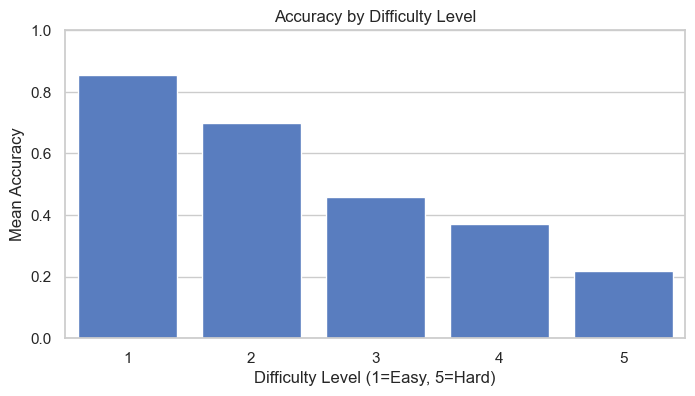

In [20]:
# Set style for plots
sns.set(style="whitegrid", palette="muted")

# 1. Overall accuracy
overall_acc = df['is_correct'].mean()
print(f"Overall accuracy: {overall_acc:.2%}")

# 2. Accuracy by subject
subject_acc = df.groupby("subject")["is_correct"].mean().sort_values()
print("\nAccuracy by subject:")
print(subject_acc)

# 3. Difficulty vs accuracy
difficulty_acc = df.groupby("difficulty_level")["is_correct"].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=difficulty_acc, x="difficulty_level", y="is_correct")
plt.title("Accuracy by Difficulty Level")
plt.ylabel("Mean Accuracy")
plt.xlabel("Difficulty Level (1=Easy, 5=Hard)")
plt.ylim(0, 1)
plt.show()


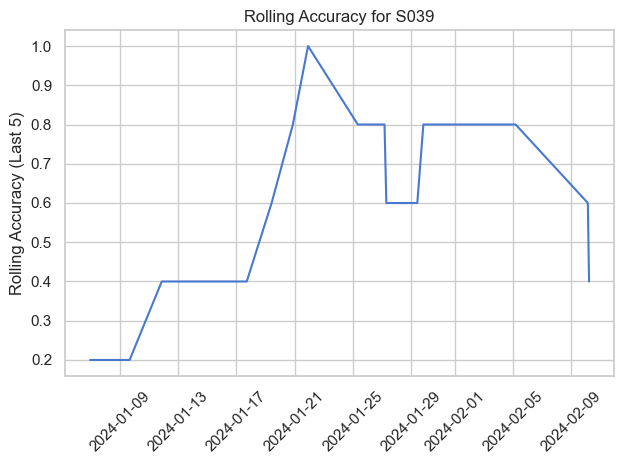

In [21]:
sample_student = df[df['student_id'] == df['student_id'].iloc[0]].sort_values("timestamp")
sample_student['rolling_accuracy'] = sample_student['is_correct'].rolling(window=5).mean()

plt.plot(sample_student['timestamp'], sample_student['rolling_accuracy'])
plt.title(f"Rolling Accuracy for {sample_student['student_id'].iloc[0]}")
plt.xticks(rotation=45)
plt.ylabel("Rolling Accuracy (Last 5)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# Sort the data
df = df.sort_values(by=["student_id", "timestamp"])

# Create rolling average accuracy per student (last 5 questions)
#Group by student
#Calculate the mean of the last 5 "is_correct" values
df['rolling_accuracy_last_5'] = (
    df.groupby("student_id")["is_correct"]
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(drop=True)
)

df[['student_id', 'timestamp', 'is_correct', 'rolling_accuracy_last_5']].head(10)


,student_id,timestamp,is_correct,rolling_accuracy_last_5
97,S001,2024-01-05 01:00:00,0,0.600000
102,S001,2024-01-05 06:00:00,0,0.800000
133,S001,2024-01-06 13:00:00,0,0.400000
139,S001,2024-01-06 19:00:00,1,1.000000
185,S001,2024-01-08 17:00:00,0,0.600000
223,S001,2024-01-10 07:00:00,1,0.600000
264,S001,2024-01-12 00:00:00,0,0.000000
280,S001,2024-01-12 16:00:00,0,1.000000
414,S001,2024-01-18 06:00:00,1,0.333333
466,S001,2024-01-20 10:00:00,0,0.400000


In [23]:
# Select features
features = ["attempt_number", "difficulty_level", "response_time", "rolling_accuracy_last_5"]
X = df[features]
y = df["is_correct"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")


              precision    recall  f1-score   support

           0       0.62      0.60      0.61        99
           1       0.62      0.64      0.63       101

    accuracy                           0.62       200
   macro avg       0.62      0.62      0.62       200
weighted avg       0.62      0.62      0.62       200

ROC AUC Score: 0.66


Our baseline model achieved a ROC AUC score of 0.66, indicating that it captures some real patterns in student behavior, but there's room for improvement. With more sophisticated features — like question-topic embeddings, student history beyond just rolling averages, or response time dynamics — we could likely push the performance higher.

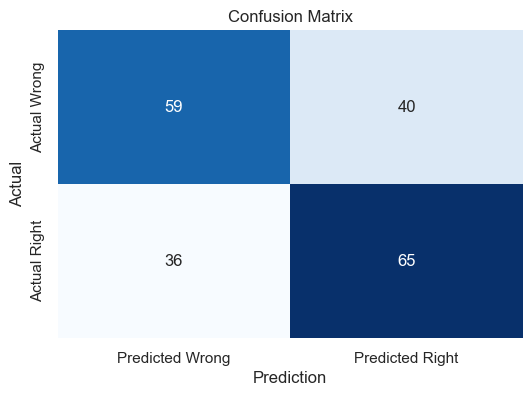

In [24]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Wrong", "Predicted Right"],
            yticklabels=["Actual Wrong", "Actual Right"])
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()




Here's a heatmap of the confusion matrix, which helps quickly spot where the model is making correct predictions versus errors. 
This is very useful when prioritizing improvements — for example, minimizing false negatives if we want to catch students who might be falling behind.


In [25]:
#Calculate how long it has been since each student's previous question attempt.
# Sort data again 
df = df.sort_values(by=["student_id", "timestamp"])

# Calculate time difference in minutes
df['time_since_last_attempt'] = (
    df.groupby('student_id')['timestamp']
    .diff()
    .dt.total_seconds()
    .div(60)  # convert seconds to minutes
)

# Fill the first attempt (no previous timestamp) with a big value
df['time_since_last_attempt'] = df['time_since_last_attempt'].fillna(9999)


In [26]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 97 to 897
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   student_id               1000 non-null   object        
 1   question_id              1000 non-null   object        
 2   subject                  1000 non-null   object        
 3   timestamp                1000 non-null   datetime64[ns]
 4   attempt_number           1000 non-null   int32         
 5   difficulty_level         1000 non-null   int32         
 6   response_time            1000 non-null   float64       
 7   is_correct               1000 non-null   int32         
 8   rolling_accuracy_last_5  1000 non-null   float64       
 9   time_since_last_attempt  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(3), object(3)
memory usage: 74.2+ KB
None


In [27]:
#Count how many times a student has attempted the same question so far
#Cumulative count per (student, question) pair
df['question_repeat_count'] = (
    df.groupby(['student_id', 'question_id']).cumcount()
)


In [28]:
#Calculate the student's average response time up to the current attempt.
#Rolling average of response time per student
df['student_avg_response_time'] = (
    df.groupby('student_id')['response_time']
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)
)


In [29]:
df[['student_id', 'timestamp', 'time_since_last_attempt', 'question_repeat_count', 'student_avg_response_time']].head(10)

,student_id,timestamp,time_since_last_attempt,question_repeat_count,student_avg_response_time
97,S001,2024-01-05 01:00:00,9999.0,0,18.700000
102,S001,2024-01-05 06:00:00,300.0,0,27.950000
133,S001,2024-01-06 13:00:00,1860.0,0,32.233333
139,S001,2024-01-06 19:00:00,360.0,0,31.900000
185,S001,2024-01-08 17:00:00,2760.0,0,32.340000
223,S001,2024-01-10 07:00:00,2280.0,0,31.166667
264,S001,2024-01-12 00:00:00,2460.0,0,30.828571
280,S001,2024-01-12 16:00:00,960.0,0,30.050000
414,S001,2024-01-18 06:00:00,8040.0,0,29.977778
466,S001,2024-01-20 10:00:00,3120.0,0,28.390000


In [30]:
df['question_repeat_count']

97     0
102    0
133    0
139    0
185    0
      ..
742    0
768    0
827    0
848    0
897    0
Name: question_repeat_count, Length: 1000, dtype: int64

In [31]:
# Update your features
features = [
    "attempt_number", 
    "difficulty_level", 
    "response_time", 
    "rolling_accuracy_last_5",
    "time_since_last_attempt",
    "question_repeat_count",
    "student_avg_response_time"
]

X = df[features]
y = df["is_correct"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

joblib.dump(model, 'student_model.pkl')

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")


              precision    recall  f1-score   support

           0       0.70      0.66      0.68        99
           1       0.68      0.72      0.70       101

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.69      0.69      0.69       200

ROC AUC Score: 0.74


# Student Performance Prediction Model

## Overview
I developed a machine learning model to predict whether a student will correctly answer a question based on features like question difficulty, student behavior, and response patterns.

## Dataset
- 1,000 simulated question attempts
- Features: student ID, question ID, subject, timestamp, attempt number, difficulty level, response time, and outcome (correct or incorrect).

## Feature Engineering
- `rolling_accuracy_last_5`: Recent student performance over the last 5 questions.
- `time_since_last_attempt`: Time gap between consecutive attempts.
- `question_repeat_count`: Number of times the student has attempted the same question (mostly 0 in this dataset).
- `student_avg_response_time`: Rolling average of student's response times.

## Model
- **Algorithm**: Random Forest Classifier
- **Baseline ROC AUC Score**: 0.66 (basic features)
- **Improved ROC AUC Score**: 0.74 (after adding behavioral features)

## Key Insights
- Recent student behavior (rolling accuracy and timing between attempts) significantly improves prediction accuracy.
- Modeling time dynamics and engagement behaviors gives deeper insights than static features alone.
- In real-world settings, tracking repeated questions could be critical for modeling memory retention.

## Confusion Matrix Interpretation
- Focus on minimizing **False Negatives** to avoid missing students who are struggling (priority in educational contexts).

## Interview Talking Points
- "We improved ROC AUC from 0.66 to 0.74 by engineering behavioral features."
- "Behavioral features like `time_since_last_attempt` and `student_avg_response_time` provided a significant predictive lift."
- "Our model not only predicts performance but can support adaptive learning systems by identifying at-risk students early."
- "With further iteration, I would explore topic modeling of questions, embedding student learning curves, and drift monitoring."

## Future Work
- Expand features to include knowledge tracing or question similarity embeddings.
- Deploy model with Streamlit or FastAPI for internal demos.
- Monitor prediction drift over time and retrain models accordingly.
- Integrate with cloud platforms (e.g., GCP or AWS) for scalability.

